In [1]:
from code.feature_extract import SignalFeatureExtractor, feature_extractor_wrapper
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostRegressor
from code.preprocess import OutlierFeatureAdder
import pandas as pd
import numpy as np
import pickle
import yaml


if __name__ == '__main__':
    print(30 * '=', 'Started Process', 30 * '=')
    with open('config.yaml', 'rb') as yaml_file:
        config = yaml.load(yaml_file, Loader=yaml.FullLoader)

    # Get file inputs
    processed_data_path = config['processed_data_path']
    processed_df = pd.read_table(processed_data_path, sep=' ')

    # File input for raw data
    raw_data_path = config['raw_data_path']

    if config['is_complex_model']:
        # init Extraction class
        extractor = SignalFeatureExtractor(raw_data_path=raw_data_path, extract_wavelet_features=True,
                                           extract_stats_features=True, extract_signal_dependent_features=True,
                                           n_processes=6)
        # Extract from raw data and join on processed data
        extracted_data = extractor.extract(processed_data=processed_df)
        # Pre-Process Data
        print(15*'=', 'Aggregate Features', 15*'=')
        extracted_data = feature_extractor_wrapper(df=extracted_data, extract_max_features=True,
                                                   extract_mean_features=True, n_processes=6)
        # Select matching columns and order
        try:
            if 'mpa' in config['model_path']:
                feature_columns = config['_features']['complex']['mpa']
            elif 'spg' in config['model_path']:
                feature_columns = config['_features']['complex']['spg']
            elif 'sps' in config['model_path']:
                feature_columns = config['_features']['complex']['sps']
            extracted_data = extracted_data[feature_columns]
        except Exception as e:
            unmatched_columns = [col for col in feature_columns if col not in extracted_data.columns.to_list()]
            print(e, f'Columns could not be selected from processed Dataframe\n {unmatched_columns}')
    else:
        # Pre-Process Data
        print(15 * '=', 'Aggregate Features', 15 * '=')
        extracted_data = feature_extractor_wrapper(df=processed_df, extract_max_features=True,
                                                   extract_mean_features=False, n_processes=4)
        # Select matching columns and order
        try:
            if 'mpa' in config['model_path']:
                feature_columns = config['_features']['simple']['mpa']
            elif 'spg' in config['model_path']:
                feature_columns = config['_features']['simple']['spg']
            elif 'sps' in config['model_path']:
                feature_columns = config['_features']['simple']['sps']
            extracted_data = extracted_data[feature_columns]
        except Exception as e:
            unmatched_columns = [col for col in feature_columns if col not in extracted_data.columns.to_list()]
            print(e, f'Columns could not be selected from processed Dataframe\n {unmatched_columns}')

    # Load Model
    with open(config['model_path'], 'rb') as pkl_file:
        catboost_pipe = pickle.load(pkl_file)



============================== Started Process ==============================
SignalFeatureExtractor:  {'raw_data_path': './data/raw_packets_obernach_SPS_20S01_0.5M01_0.03G02_0.03G01_5020.vlnd', 'extract_wavelet_features': True, 'extract_stats_features': True, 'extract_signal_dependent_features': True, 'n_processes': 6}
=============== Extracting for Function: _wavelet_feature_extraction ===============
INFO || 22.01.04_09:33 | Extracting Features
INFO || 22.01.04_09:33 | Load Raw Data
INFO || 22.01.04_09:33 | Extracting from Raw
INFO || 22.01.04_09:33 | Transform Features
INFO || 22.01.04_09:33 | Joining new Features
=============== Extracting for Function: _statistical_feature_extraction ===============
INFO || 22.01.04_09:33 | Extracting Features
INFO || 22.01.04_09:33 | Load Raw Data
INFO || 22.01.04_09:33 | Extracting from Raw
INFO || 22.01.04_09:33 | Transform Features
INFO || 22.01.04_09:33 | Joining new Features
=============== Extracting for Function: _signal_dependent_feature

In [2]:
XX = catboost_pipe["outlier_feature"].transform(extracted_data)
five_pr = int(len(XX)/100*5)
XX_5 = XX.sample(five_pr)
X = catboost_pipe["power_transform"].transform(XX_5)

In [3]:
col_names = XX.columns

In [212]:
len(col_names)

89

In [4]:
X_df = pd.DataFrame(X)

In [5]:
X_df.columns = col_names

In [6]:
import matplotlib.pyplot as plt

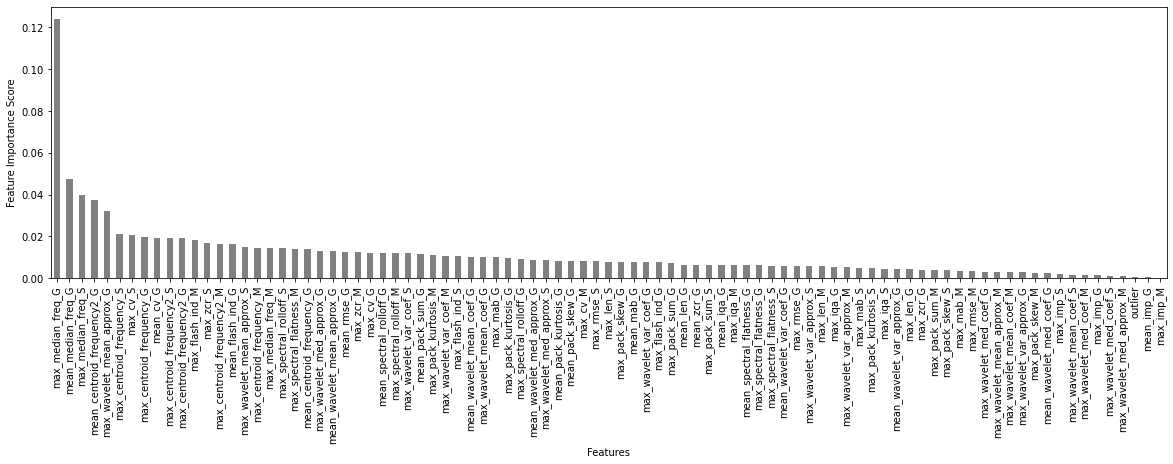

In [211]:

importances = dict(zip(X_df.columns, catboost_pipe["cat_boost"].feature_importances_/100)) 
importances = pd.DataFrame(data=importances.values(), columns=['Importance'], index=importances.keys())
importances.sort_values(by='Importance', ascending=False).plot(kind='bar', figsize=(20, 5),color = "gray",legend=False)
plt.xlabel("Features")
plt.ylabel("Feature Importance Score")
plt.show()

In [191]:
top_list = list(importances.sort_values(by='Importance', ascending=False)[:15].index)

In [192]:
import shap

In [193]:
explainer = shap.Explainer(catboost_pipe["cat_boost"])

In [194]:
shap_values = explainer(X_df)

In [195]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [[128/255,128/255,128/255],[1,1,1],[31/255,119/255,180/255]])

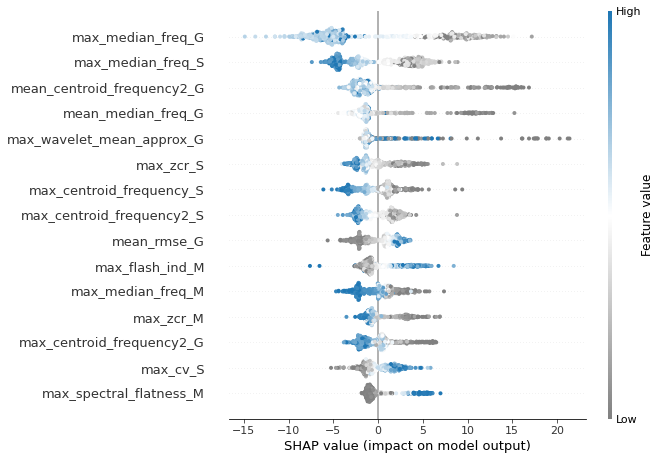

In [207]:
shap.plots.beeswarm(shap_values[:,shap_values.abs.mean(0).argsort[-15:]],color=plt.get_cmap(cmap),max_display=15)